# 設定

In [151]:
import os
from dotenv import load_dotenv
import time
load_dotenv()

BITMART_API_KEY = os.getenv("BITMART_API_KEY")
BITMART_SECRET_KEY = os.getenv("BITMART_SECRET_KEY")
BITMART_MEMO = os.getenv("BITMART_MEMO")
TOPONE_API_KEY = os.getenv("TOPONE_API_KEY")
TOPONE_SECRET_KEY = os.getenv("TOPONE_SECRET_KEY")

# bitmart 客戶端


In [152]:
import logging
import time
import pandas as pd
from bitmart.api_contract import APIContract
from bitmart.lib.cloud_exceptions import APIException
import math

# 設定 logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger("bitmart").setLevel(logging.ERROR)
logging.getLogger("urllib3").setLevel(logging.ERROR)

class BitmartClient:
    def __init__(self, api_key: str, secret_key: str, memo: str):
        self.futuresAPI = APIContract(api_key=api_key, secret_key=secret_key, memo=memo)
        self.logger = logging.getLogger(__name__)

    def get_balance(self):
        try:
            response = self.futuresAPI.get_assets_detail()[0]
            usdt_asset = next((asset for asset in response['data'] if asset['currency'] == 'USDT'), None)
            if usdt_asset:
                return float(usdt_asset['available_balance'])
            else:
                self.logger.info("USDT asset not found")
                return None
        except APIException as error:
            self.logger.error(f"Found error. status: {error.status_code}, error message: {error.response}")
            return None
    
    def get_current_price(self, symbol: str):
        try:
            depth_data = self.futuresAPI.get_depth(symbol)[0]['data']
            if depth_data and depth_data.get('bids') and depth_data.get('asks'):
                best_bid = float(depth_data['bids'][0][0])
                best_ask = float(depth_data['asks'][0][0])
                return (best_bid + best_ask) / 2
            else:
                self.logger.error(f"Could not get bids/asks from depth data.")
                return None
        except (APIException, IndexError, KeyError) as error:
            self.logger.error(f"Failed to get depth: {error}")
            return None
    
    def get_kline_data(self, symbol: str, step: int, start_time: int, end_time: int):
        """
        抓取 BitMart 合約 K 線資料（自動分段抓取長歷史資料）
        輸入: 
            symbol: 交易對
            step: K線間隔，分鐘
            start_time: UNIX timestamp(秒)
            end_time: UNIX timestamp(秒)
        輸出: DataFrame(['datetime','open','high','low','close','volume'])
        """
        try:
            all_data = []
            current_start = start_time
            seconds_per_bar = step * 60
            max_bars = 999  # API 一次最多返回 K 線數量

            while current_start < end_time:
                # 計算這段抓多少秒，避免超過 max_bars
                segment_seconds = max_bars * seconds_per_bar
                current_end = min(current_start + segment_seconds, end_time)

                # 單次抓取
                kline_response = self.futuresAPI.get_kline(symbol, step, current_start, current_end)
                df = pd.DataFrame(kline_response[0]['data'], columns=["timestamp", "open_price", "high_price",
                                                                    "low_price", "close_price", "volume"])
                df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
                df = df.astype({
                    "open_price": float,
                    "high_price": float,
                    "low_price": float,
                    "close_price": float,
                    "volume": float
                })
                df = df.rename(columns={
                    "timestamp": "datetime",
                    "open_price": "open",
                    "high_price": "high",
                    "low_price": "low",
                    "close_price": "close",
                    "volume": "volume"
                })

                all_data.append(df)

                if df.empty:
                    break

                # 下一段開始時間
                current_start = int(df['datetime'].iloc[-1].timestamp()) + seconds_per_bar
                time.sleep(0.2)  # 避免請求過快

            if all_data:
                full_df = pd.concat(all_data, ignore_index=True)
                full_df = full_df.drop_duplicates(subset='datetime').sort_values('datetime').reset_index(drop=True)
                return full_df
            else:
                return pd.DataFrame(columns=['datetime','open','high','low','close','volume'])

        except (APIException, IndexError, KeyError) as e:
            self.logger.error(f"Failed to get kline data for {symbol}: {e}")
            return None

    def place_order(self, symbol: str, side: str, margin: float, leverage: int, tp_price: float, sl_price: float):
        current_price = self.get_current_price(symbol)
        details_data = self.futuresAPI.get_details(symbol)[0]['data']
        symbol_details = details_data['symbols'][0]
        contract_size = float(symbol_details['contract_size'])    
        notional_value = margin * leverage
        contract_value = current_price * contract_size
        size = math.floor(notional_value / contract_value)
        self.futuresAPI.post_submit_leverage(contract_symbol=symbol,leverage=str(leverage),open_type="isolated")
        print(size,notional_value,contract_value)

In [153]:
# 初始化 BitmartClient
bitmart_client = BitmartClient(BITMART_API_KEY, BITMART_SECRET_KEY, BITMART_MEMO)
# 查詢 K線
end_time = int(time.time())
start_time = end_time - 100000  # 過去一小時
kline = bitmart_client.get_kline_data('BTCUSDT', 15, start_time, end_time)
display(kline)

,datetime,open,high,low,close,volume
0,2025-11-04 03:45:00,106983.0,107202.1,106960.4,107097.2,370008.0
1,2025-11-04 04:00:00,107097.2,107247.8,107050.6,107144.1,761592.0
2,2025-11-04 04:15:00,107144.2,107144.2,106851.4,106884.7,519650.0
3,2025-11-04 04:30:00,106884.7,106995.0,106728.6,106793.6,702012.0
4,2025-11-04 04:45:00,106793.6,106845.3,106659.5,106702.7,388776.0
...,...,...,...,...,...,...
107,2025-11-05 06:30:00,101864.6,102012.5,101677.8,101836.4,793868.0
108,2025-11-05 06:45:00,101836.3,102121.4,101768.2,102068.7,758172.0
109,2025-11-05 07:00:00,102068.7,102099.9,101697.9,101880.1,681630.0
110,2025-11-05 07:15:00,101872.4,101890.4,101544.4,101769.7,738668.0


# voger

In [154]:
import pandas as pd
import numpy as np

def voger_plus_signals(df, cciLen=20, atrLen=20, atrMult=1.0, smoothing=5, lookbackBars=5):
    """
    df: DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
    Returns: Series of signals: 1=Buy, -1=Sell, 0=No Signal
    """
    
    close = df['close']
    high = df['high']
    low = df['low']
    
    # === CCI ===
    TP = (high + low + close) / 3
    sma_tp = TP.rolling(cciLen).mean()
    mean_dev = TP.rolling(cciLen).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci = (TP - sma_tp) / (0.015 * mean_dev)
    
    # === ATR ===
    high_low = high - low
    high_close = np.abs(high - close.shift(1))
    low_close = np.abs(low - close.shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(atrLen).mean()
    
    # === Trend Magic ===
    upTrend = close - atrMult * atr
    dnTrend = close + atrMult * atr
    rawTrendMagic = np.where(cci >= 0, upTrend, dnTrend)
    trendMagic = pd.Series(rawTrendMagic).rolling(smoothing).mean()
    
    # === Trend Direction ===
    trendUp = cci >= 0
    trendUpPrev = trendUp.shift(1).fillna(False)
    
    # === Lookback High/Low ===
    prevHigh = close.shift(1).rolling(lookbackBars).max()
    prevLow = close.shift(1).rolling(lookbackBars).min()
    
    isAboveLookback = (lookbackBars == 0) | (close > prevHigh)
    isBelowLookback = (lookbackBars == 0) | (close < prevLow)
    
    # === Signals ===
    bullCross = (~trendUpPrev) & trendUp & isAboveLookback
    bearCross = trendUpPrev & (~trendUp) & isBelowLookback
    
    # 1=Buy, -1=Sell, 0=No signal
    signals = pd.Series(0, index=df.index)
    signals[bullCross] = 1
    signals[bearCross] = -1
    
    return signals
signal = voger_plus_signals(kline)
signal.value_counts()

 0    105
 1      4
-1      3
Name: count, dtype: int64

In [155]:
import plotly.graph_objects as go
import numpy as np

kline['signal'] = signal

fig = go.Figure()

# K線圖
fig.add_trace(go.Candlestick(
    x=kline['datetime'],
    open=kline['open'],
    high=kline['high'],
    low=kline['low'],
    close=kline['close'],
    name='K線'
))

# 買入信號 🚀
buy_signals = kline[kline['signal'] == 1]
fig.add_trace(go.Scatter(
    x=buy_signals['datetime'],
    y=buy_signals['low'],
    mode='text',
    text=['🚀' for _ in buy_signals],
    textposition="bottom center",
    name='買入信號'
))

# 賣出信號 🪂
sell_signals = kline[kline['signal'] == -1]
fig.add_trace(go.Scatter(
    x=sell_signals['datetime'],
    y=sell_signals['high'],
    mode='text',
    text=['🪂' for _ in sell_signals],
    textposition="top center",
    name='賣出信號'
))

# 調整圖高度與邊距
fig.update_layout(
    title='Voger 指標 K線圖',
    xaxis_rangeslider_visible=True,  # 可互動拉動
    height=800,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.show()


# 報酬曲線

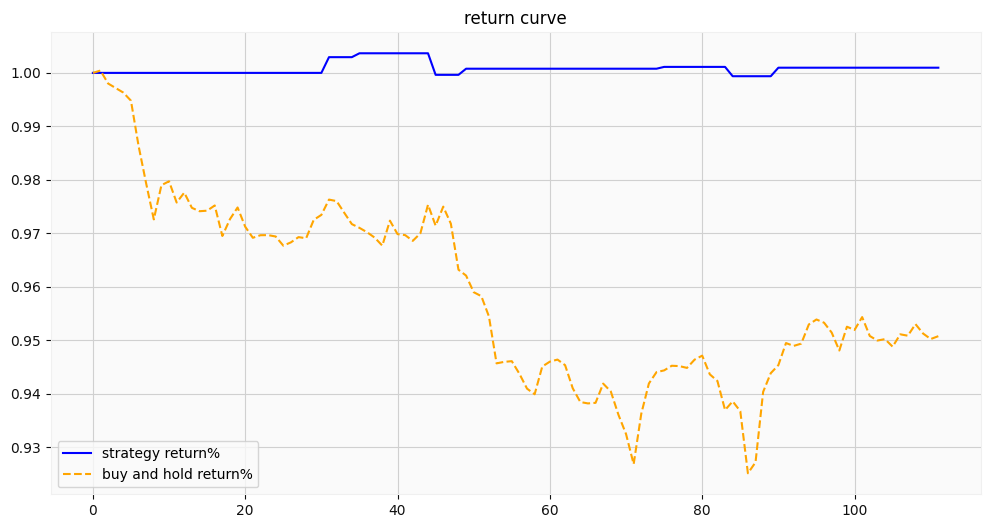

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設 kline 已有 'close' 和 'signal'

# 初始化倉位：1=多, -1=空, 0=平倉
positions = kline['signal'].shift(1).fillna(0)  # shift(1) 表示信號在下一根K線才生效

# 計算每日報酬率
returns = positions * kline['close'].pct_change().fillna(0)

# 計算累積報酬
cumulative_returns = (1 + returns).cumprod()

# 畫圖
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='strategy return%', color='blue')
plt.plot((1 + kline['close'].pct_change().fillna(0)).cumprod(), 
         label='buy and hold return%', color='orange', linestyle='--')
plt.title('return curve')
plt.legend()
plt.grid(True)
plt.show()
